In [391]:
import numpy as np
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
from Bio.SVDSuperimposer import SVDSuperimposer

from numpy import array, dot, set_printoptions

In [392]:
# link to openmm manual for how to set up a minimizer
# http://docs.openmm.org/7.2.0/userguide/application.html

In [393]:
def get_rot_and_trans(subtraj_A,subtraj_B):
    
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
         even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # Set the coords, y will be rotated and translated on x
    x = subtraj_A.xyz[0]
    y = subtraj_B.xyz[0]
    sup.set(x, y)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms

def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

def update_topology(C):
    top = C.top
    # Merge two tops (with two chains or more) to a top of one chain 
    out = md.Topology()
    c = out.add_chain()
    for chain in top.chains:

        for residue in chain.residues:
            r = out.add_residue(residue.name, c, residue.resSeq, residue.segment_id)
            for atom in residue.atoms:
                out.add_atom(atom.name, atom.element, r, serial=atom.serial)
    #     for bond in top.bonds:
    #         a1, a2 = bond
    #         out.add_bond(a1, a2, type=bond.type, order=bond.order)
    out.create_standard_bonds() #rare manier om bonds te maken, maar werkt
    C.top = out 
    return C

def fit_B_on_A(A, B, selection_A, selection_B, delete_overlap=False):
    
    # create trajs containing only the selections
    subtraj_A = A.atom_slice(selection_A)
    subtraj_B = B.atom_slice(selection_B)

    # obtain instructions to rotate and translate B on A based on substraj structures
    rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)
    
    # do the superimposition of B on A and subsitute old with new xyz of B
    new_B = apply_superimposition(B, rot, tran)

    
    if delete_overlap:
        # remove selection from A and add new B
        selection_to_delete = selection_A 
        new_A = A.atom_slice([at.index for at in A.top.atoms if at.index not in selection_to_delete])

        # merge superimposed structure and fit (A and B*) and update topology such that they share a chain
        C = update_topology(new_A.stack(new_B))
    else:
         C = A.stack(new_B)
            
    return C, rms

In [394]:
# Load H-NS s1s1 dimers
loc_dimers = './data/0_s1s1/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,16)]
start_open = md.load(loc_dimers+f'dry_open.xtc',top=loc_dimers+f'dry_open.pdb').remove_solvent()
start_closed = md.load(loc_dimers+f'dry_closed.xtc',top=loc_dimers+f'dry_closed.pdb').remove_solvent()

#s1s1 = md.join([start_open,start_closed,md.join(short_trajs)])
s1s1 = md.join(short_trajs)

In [5]:
# Load H-NS s2s2 dimers
loc_dimers = './data/1_s2s2/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,10)]

s2s2 = md.join(short_trajs)

In [6]:
def check_selection(top,selection):
    
    if selection == 'CA':
        indices = top.select('name CA')
    elif selection == 'backbone':
        indices = top.select('backbone')
    elif selection == 'sidechain':
        indices = top.select('sidechain')
    else:
        indices = top.select('all')   
    return indices 

def get_monomer_domain_indices(top,domain,chain=0,selection=None):
    
    residues = np.array(top._chains[chain]._residues)
    indices = check_selection(top,selection)
    return [at.index for res in residues[domain] for at in res.atoms if at.index in indices]
    

def show_domain(system,domain):
    # shows first frame
    top = system.top
    view = nv.show_mdtraj(system[0])
    view.clear()
    indices = get_monomer_domain_indices(top,domains[domain],chain=0)
    view.add_representation('cartoon',selection=[i for i in  top.select('all') if i not in indices],color='cornflowerblue')
    top = system.topology
    chain_id = 0
    indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id)
    view.add_representation('cartoon',selection=indices,color='gold')
    top = system.topology
    chain_id = 1
    indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id)
    view.add_representation('cartoon',selection=indices,color='red')
    return view


domains = {'s1':np.arange(0,41),
           's2':np.arange(53,82),
           'dbd':np.arange(95,137),
           'h1':np.arange(1,8),
           'h2':np.arange(11,19),
           'h3':np.arange(41,50),
           'l1':np.arange(50,53),
           'h4':np.arange(71,82),
           'l2':np.arange(82,95)}

# top = s1s1.topology
# chain_id = 0
# domain = 's1'
# # selection options are CA (carbon alpha), backbone, and sidechain, or None (all)
# indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id,selection='CA')

In [385]:
show_domain(s1s1,'l2')

NGLWidget()

In [386]:
show_domain(s2s2[-1],'l2')

NGLWidget()

### RMSD/RMSF analysis

In [56]:
def get_rmsd_domains(system,ref,domains,selection='CA'):
    data = {}
    for name,resids in domains.items():
        rms = []
        for chain_id in [0,1]:
            indices = get_monomer_domain_indices(system.top,resids,chain=chain_id,selection=selection)
            rms.append(md.rmsd(system,reference=ref,atom_indices=indices))
        data[name] = rms
    return data

In [57]:
selection = 'CA'
rmsds_s1 = {}
rmsds_s2 = {}
ref1 = s1s1[0] # open conf
ref2 = s2s2[0] # strechted conf
#ref1 = ref2

rmsds_s1s1 = get_rmsd_domains(s1s1,ref1,domains,selection)
rmsds_s2s2 = get_rmsd_domains(s2s2,ref2,domains,selection)

rmsf_s1s1 = md.rmsf(s1s1,ref1,atom_indices=s1s1.top.select(f'name {selection}'))
rmsf_s2s2 = md.rmsf(s2s2,ref2,atom_indices=s2s2.top.select(f'name {selection}'))

### plot RMSF

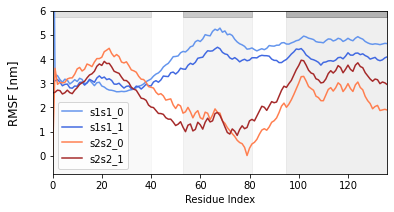

In [52]:
def plot_rmsf_monomer(ax,rmsf,label=None,fill=False,color='gray'):
    colors = sns.color_palette('Greys',5)[1:4]
    
    idx = 0
    for name,resids in domains.items():
        if idx > 2:
            break
        if fill:
            ax.fill_between(resids,[6]*len(resids),[5.75]*len(resids),alpha=0.5,color=colors[idx])
            ax.fill_between(resids,[-0.75]*len(resids),[5.75]*len(resids),alpha=0.1,color=colors[idx])
        idx+=1
    ax.plot(rmsf,label=label,color=color)
    
fig,ax =plt.subplots(1,1,sharey=True,sharex=True,figsize=[6,3])

n = len(rmsf_s1s1)
s1rmsf_a = rmsf_s1s1[:n//2]
s1rmsf_b = rmsf_s1s1[n//2:]
s2rmsf_a = rmsf_s2s2[:n//2]
s2rmsf_a[0] = 0
s2rmsf_b = rmsf_s2s2[n//2:]

plot_rmsf_monomer(ax,s1rmsf_a,fill=False,color='cornflowerblue',label='s1s1_0')
plot_rmsf_monomer(ax,s1rmsf_b,color='royalblue',label='s1s1_1')
plot_rmsf_monomer(ax,s2rmsf_a,fill=True,color='coral',label='s2s2_0')
plot_rmsf_monomer(ax,s2rmsf_b,color='brown',label='s2s2_1')

ax.set_xlim(0,136)
ax.set_ylim(-0.75,6)

list(domains.keys())[:]

fig.supylabel('RMSF [nm]')
ax.set_xlabel('Residue Index')
ax.legend()

### plot RMSD

Text(128.625, 0.5, 'RMSD [nm]')

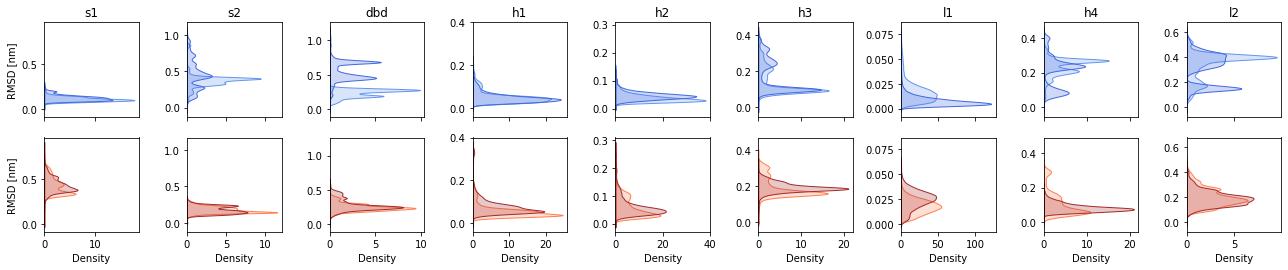

In [60]:
fig,axes = plt.subplots(2,len(list(rmsds_s1s1.keys())),figsize=[18,3.5],sharey='col',sharex='col')
fig.tight_layout()

ax = axes[0]
idx = 0
for domain,monomers in rmsds_s1s1.items():
    sns.kdeplot(ax=ax[idx],y=monomers[0],fill=True,color='cornflowerblue')
    sns.kdeplot(ax=ax[idx],y=monomers[1],fill=True,color='royalblue')
    ax[idx].set_title(domain)
    idx+=1
ax[0].set_ylabel('RMSD [nm]')
    
ax = axes[1]
idx = 0
for domain,monomers in rmsds_s2s2.items():
    sns.kdeplot(ax=ax[idx],y=monomers[0],fill=True,color='coral')
    sns.kdeplot(ax=ax[idx],y=monomers[1],fill=True,color='brown')
    idx+=1
ax[0].set_ylabel('RMSD [nm]')
    

Text(0.5, 0.01, 'RMSD [nm]')

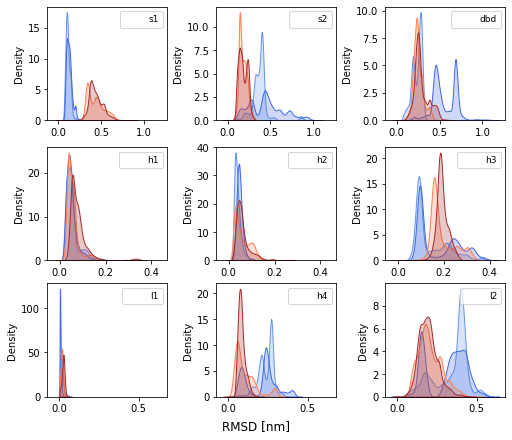

In [62]:
fig,axes = plt.subplots(3,3,figsize=[7,6],sharex='row',sharey=False,constrained_layout=True)

from matplotlib.lines import Line2D
ax = axes.flatten()
idx = 0
for domain,monomers in rmsds_s1s1.items():
    sns.kdeplot(ax=ax[idx],x=monomers[0],fill=True,color='cornflowerblue')
    sns.kdeplot(ax=ax[idx],x=monomers[1],fill=True,color='royalblue')
    # ax[idx].set_title(domain)
    ax[idx].legend(domain,loc="upper right")
    
    legend_elements = [Line2D([0], [0], color='gray', lw=0, label=domain)]
    ax[idx].legend(handles=legend_elements, loc='upper right',fontsize=9)

    idx+=1
#ax[0].set_ylabel('RMSD [nm]')
    
ax = axes.flatten()
idx = 0
for domain,monomers in rmsds_s2s2.items():
    sns.kdeplot(ax=ax[idx],x=monomers[0],fill=True,color='coral')
    sns.kdeplot(ax=ax[idx],x=monomers[1],fill=True,color='brown')
    idx+=1
    
fig.supxlabel('RMSD [nm]')
    

### Domain Analysis

In [ ]:
# contacts between interdomains en intradomains 

In [177]:
system = s2s2
top = system.top
selection = 'CA'
monomer = 1
domain_indices = {name:get_monomer_domain_indices(top, domain, chain=monomer, selection=selection) for name,domain in domains.items()}


In [178]:
def get_contacts(system,domain_indices,domain_A,domain_B):
    indices_A = domain_indices[domain_A]
    indices_B = domain_indices[domain_B]
    pairs = [[i,j] for i in indices_A for j in indices_B]
    distances = md.compute_distances(system,pairs)
#    return pairs,distances
    return np.mean(distances,axis=1)

In [179]:
keys = ['s1','s2','dbd']
pairs = [[A,B] for A in keys for B in keys if A!=B]
pairs = np.unique(np.sort(pairs),axis=0)

C = [get_contacts(system[::10],domain_indices,A,B) for A,B in pairs]

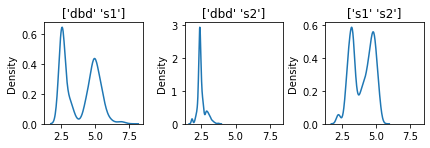

In [176]:
fig,axes = plt.subplots(1,len(pairs),figsize=[2*len(pairs),2],sharex=True,sharey=False)
axes = axes.flatten()
fig.tight_layout()
idx = 0
for ax,c in zip(axes,C):
    sns.kdeplot(c,ax=ax)
    ax.set_title(str(pairs[idx]))
    idx+=1
    
# s1s1

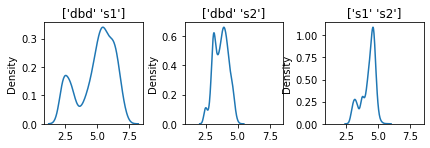

In [377]:
fig,axes = plt.subplots(1,len(pairs),figsize=[2*len(pairs),2],sharex=True,sharey=False)
axes = axes.flatten()
fig.tight_layout()
idx = 0
for ax,c in zip(axes,C):
    sns.kdeplot(c,ax=ax)
    ax.set_title(str(pairs[idx]))
    idx+=1
    
# s2s2

In [308]:
def _displacement(xyz, pairs):
    "Displacement vector between pairs of points in each frame"
    value = np.diff(xyz[:, pairs], axis=2)[:, :, 0]
    assert value.shape == (xyz.shape[0], pairs.shape[0], 3), 'v.shape %s, xyz.shape %s, pairs.shape %s' % (str(value.shape), str(xyz.shape), str(pairs.shape))
    return value

def _angle(traj, angle_indices):
    
    ix01 = angle_indices[:, [1, 0]]
    ix21 = angle_indices[:, [1, 2]]

    u_prime = _displacement(traj, ix01)
    v_prime = _displacement(traj, ix21)
    u_norm = np.sqrt((u_prime**2).sum(-1))
    v_norm = np.sqrt((v_prime**2).sum(-1))

    # adding a new axis makes sure that broasting rules kick in on the third
    # dimension
    u = u_prime / (u_norm[..., np.newaxis])
    v = v_prime / (v_norm[..., np.newaxis])

    return np.arccos((u * v).sum(-1))

def find_arm(system,domains,chain_id=0,selection='CA'):
    
    shoulder = get_monomer_domain_indices(system.top,domains['s1'],chain=chain_id,selection=selection)
    elbow = get_monomer_domain_indices(system.top,domains['s2'],chain=chain_id,selection=selection)
    fist = get_monomer_domain_indices(system.top,domains['dbd'],chain=chain_id,selection=selection)
    return [shoulder, elbow, fist]

def compute_com_arm(traj, arm):
    return np.array([md.compute_center_of_mass(traj.atom_slice(part)) for part in arm]).swapaxes(0,1)

def compute_arm_angle(system,domains,chain_id=0,selection='CA'):
    arm = find_arm(system,domains,chain_id=chain_id,selection=selection)
    com_arm = compute_com_arm(system,arm)
    return _angle(com_arm,np.array([[0,1,2]])).T[0]

In [309]:
k = 1
selection='backbone'
s1alpha_0 = compute_arm_angle(s1s1[::k],domains,chain_id=0,selection=selection)
s1alpha_1 = compute_arm_angle(s1s1[::k],domains,chain_id=1,selection=selection)

s2alpha_0 = compute_arm_angle(s2s2[::k],domains,chain_id=0,selection=selection)
s2alpha_1 = compute_arm_angle(s2s2[::k],domains,chain_id=1,selection=selection)

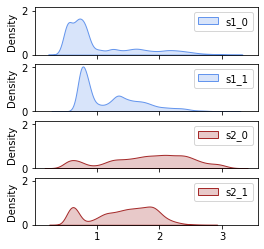

In [379]:
fig,axes = plt.subplots(4,1,sharex=True,sharey=True,figsize=[4,4])

names = ['s1_0','s1_1','s2_0','s2_1']
idx = 0
for ax,alpha in zip(axes,[s1alpha_0,s1alpha_1,s2alpha_0,s2alpha_1]):
    if 's1' in names[idx]:
        c = 'cornflowerblue'
    else:
        c = 'brown'
    sns.kdeplot(x=alpha,ax=ax,fill=True,label=names[idx],color=c)
    ax.legend()
    idx+=1
    

(0.0, 3.141592653589793)

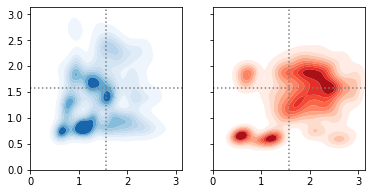

In [250]:
fig,ax=plt.subplots(1,2,figsize=[6,3],sharey=True,sharex=True)

sns.kdeplot(x=s1alpha_0,y=s1alpha_1,ax=ax[0],shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(x=s2alpha_0,y=s2alpha_1,ax=ax[1],shade=True,antialiased=True,cmap='Reds')
for x in ax:
    x.axhline(np.pi/2,c='gray',ls=':')
    x.axvline(np.pi/2,c='gray',ls=':')
x.set_xlim(0,np.pi)
x.set_ylim(0,np.pi)

# without long open and closed trajs s1s1

(0.0, 3.141592653589793)

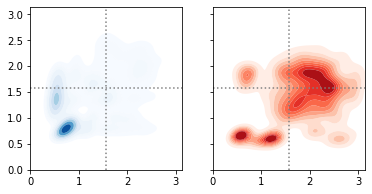

In [310]:
fig,ax=plt.subplots(1,2,figsize=[6,3],sharey=True,sharex=True)

sns.kdeplot(x=s1alpha_0,y=s1alpha_1,ax=ax[0],shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(x=s2alpha_0,y=s2alpha_1,ax=ax[1],shade=True,antialiased=True,cmap='Reds')
for x in ax:
    x.axhline(np.pi/2,c='gray',ls=':')
    x.axvline(np.pi/2,c='gray',ls=':')
x.set_xlim(0,np.pi)
x.set_ylim(0,np.pi)

# with long open and closed trajs s1s1

(0.0, 180.0)

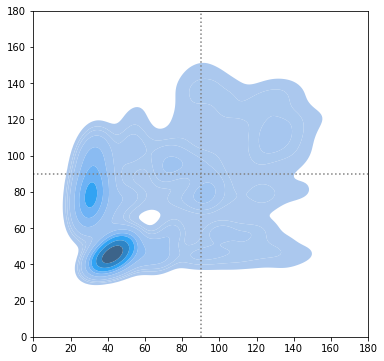

In [311]:
fig,ax=plt.subplots(1,1,figsize=[6,6])
sns.kdeplot(x=np.rad2deg(s1alpha_0),y=np.rad2deg(s1alpha_1),ax=ax,shade=True,antialiased=True)

ax.axhline(90,c='gray',ls=':')
ax.axvline(90,c='gray',ls=':')
ax.set_xlim(0,180)
ax.set_ylim(0,180)

### Cluster Alpha's

In [356]:
from sklearn.cluster import KMeans

def kmcluster_alpha(alpha_0,alpha_1,n_clusters=10):
    X = np.array([alpha_0,alpha_1]).T
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return X, kmeans

def plot_kmeans(ax, kmeans, X):
    
    y_kmeans = kmeans.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=1, cmap='viridis',alpha=0.75)
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

    ax.axhline(np.pi/2,c='gray',ls=':')
    ax.axvline(np.pi/2,c='gray',ls=':')
    ax.set_xlim(0,np.pi)
    ax.set_ylim(0,np.pi)

In [389]:
n_clusters = 6
s1s1_X, s1s1_alpha_clusters = kmcluster_alpha(s1alpha_0,s1alpha_1,n_clusters)
s2s2_X, s2s2_alpha_clusters = kmcluster_alpha(s2alpha_0,s2alpha_1,n_clusters)

Text(0, 0.5, 'Alpha_1 (radians)')

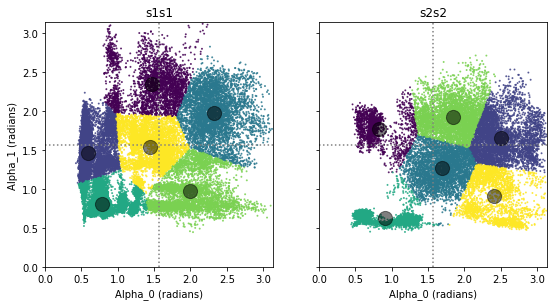

In [390]:
fig,ax=plt.subplots(1,2,figsize=[9,4.5],sharex=True,sharey=True)

plot_kmeans(ax[0],s1s1_alpha_clusters,s1s1_X)
plot_kmeans(ax[1],s2s2_alpha_clusters,s2s2_X)
ax[0].set_title('s1s1')
ax[1].set_title('s2s2')
ax[1].set_xlabel('Alpha_0 (radians)')
ax[0].set_xlabel('Alpha_0 (radians)')
ax[0].set_ylabel('Alpha_1 (radians)')

In [ ]:
# configurational bias monte carlo filament generation 